In this lab, you are supposed to do the following tasks related to stochastic non-linear filtering.

1. Simulation of a non-linear SSM.
2. Solve the filtering problem with an extended Kalman filter.
3. Solve the filtering problem with a quadrature filter.

We will use the Newtonian dynamics model with distance and bearning measurement in LE 4-5 as the example.

To pass this assignment, you need to pass all the tasks and answer the questions (except for those marked optional). You are also asked to report the contributions if you worked in a team.

## Note
To get a result consistent with the teacher's:

1. Use "Run All".
2. Do not change the random seed.
3. Do not change the plotting settings. If you encounter any issue related to LaTeX rendering, you can comment out the `text.usetex: True` item in `plt.rcParams.update`.

# Setup
Let's first import necessary libraries and set a random seed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import jax
import jax.numpy as jnp
from typing import Tuple


np.random.seed(888)

plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 20})

# Task 1: Motion model with non-linear observations: simulation
Your first task is to simulate a state path $X_{0:N} \coloneqq \lbrace X_0, X_1, \ldots, X_N \rbrace$ and observation path $Y_{0:N} \coloneqq \lbrace Y_0, Y_1, \ldots, Y_N \rbrace$ from a non-linear state-space model.
The example model here describes the motion of a moving object in 2D space, but this is more advanced than the Newtonian dynamics model previously used (this will be explained at the lab session).
In differential equation form, the model is described by
$$
\begin{equation}
    \begin{split}
        \mathrm{d}
        \begin{bmatrix}
            p_t^1 \\ p_t^2 \\ v_t \\ \omega_t
        \end{bmatrix}
        =
        \begin{bmatrix}
            v_t \cos(\omega_t) \\
            v_t \sin(\omega_t) \\
            0 \\
            a \, \omega_t
        \end{bmatrix} \mathrm{d}t + \text{``noise''}
    \end{split}
\end{equation}
$$
where $p_t^1$ and $p_t^2$ are the coordinates of the object at time $t$, $v_t$ is the speed, and $\omega_t$ is the angle of the object at time $t$. The parameter $a$ is a constant that essentially controls how fast the angle changes.
This model can be "approximately" represented by a non-linear SSM as follows:

$$
\begin{equation}
    \begin{split}
        X_0 &\sim \mathrm{N}(m_0, V_0), \\
        X_k &= f(X_{k-1}) + q_k, \quad q_k \sim \mathrm{N}(0, \Sigma), \\
        Y_k &= h(X_k) + \xi_k, \quad \xi_k \sim \mathrm{N}(0, \Xi).
    \end{split}
\end{equation}
$$
where $X_k \coloneqq \begin{bmatrix}p_k^1 & p_k^2 & v_k & \omega_k \end{bmatrix}$ encodes the position, velocity, and angle of the object at time $t_k$ in the 2D space, and
$$
f(X_k) =
\begin{bmatrix}
    p_{k-1}^1 + v_{k-1} \cos(\omega_{k-1}) \Delta \\
    p_{k-1}^2 + v_{k-1} \sin(\omega_{k-1}) \Delta \\
    v_{k-1} \\
    \exp(a \, \Delta) \omega_{k-1}
\end{bmatrix}, \quad
\Sigma =
\begin{bmatrix}
    \Delta^3 / 3 & 0 & 0 & 0 \\
    0 & \Delta^3 / 3 & 0 & 0 \\
    0 & 0 & \Delta & 0 \\
    0 & 0 & 0 & \frac{b^2}{2 \, a} (\exp(2 \,a \,\Delta) - 1)
\end{bmatrix}.
$$

We set $a=-1$ and $b=\sqrt{2}$.

Now we assume that we have a radar at the position $(r_1, r_2)$, and it measures the relative distance and bearing to the object:
$$
h(X_k) =
\begin{bmatrix}
    \sqrt{(p_k^1 - r_1)^2 + (p_k^2 - r_2)^2} \\
    \arctan((p_k^2 - r_2) \, / \, (p_k^1 - r_1))
\end{bmatrix}, \quad
\Xi =
\begin{bmatrix}
    1. & 0 \\
    0 & 10^{-2}
\end{bmatrix},
$$

We consider that the object moves within time $t=[0, T]$, where $T = 10$ seconds, and we discretise the time with $N=1000$ steps, resulting in a time step size of $\Delta = 0.01$ seconds.

## Note
When you implement `arctan`, use `np.atan2` to avoid the singularity problem.

In [2]:
# As usual, let us first set the time that we work on

t0 = 0.  # The initial time
nsteps = 1000  # The number of time steps
T = 10.  # The final time
ts = np.linspace(t0, T, nsteps + 1)  # The times
dt = T / nsteps  # The time step size \Delta

Now we want to simulate a path $X_{0:N}$ from the SSM at the time steps $t_0 < t_1 < \cdots < t_N = T$, and the corresponding observations $Y_{0:N}$.

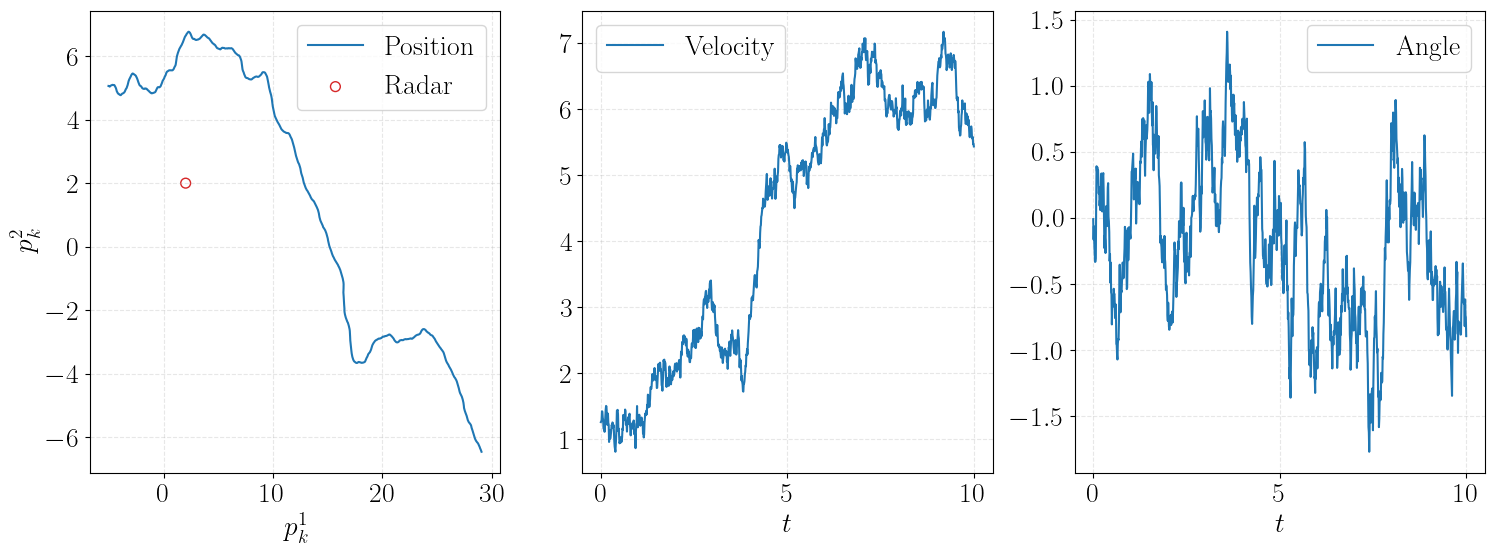

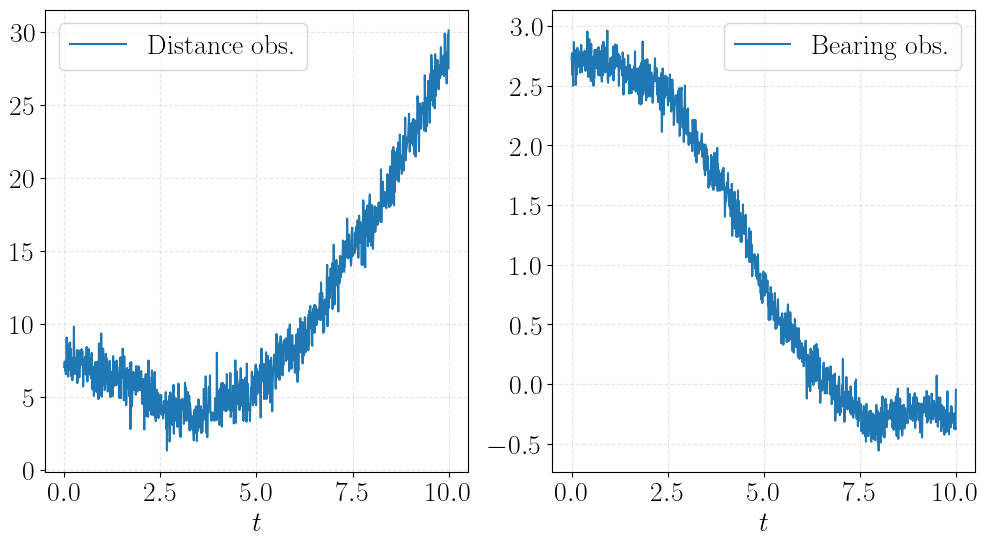

In [3]:
d = 4  # The dimension of the state
dy = 2  # The dimension of the observation

a, b = -1, 2 ** 0.5  # constants


def f(x: np.ndarray) -> np.ndarray:
    """Non-linear state transition function

    Parameters
    ----------
    x : np.ndarray (d, )
        The state at time t_k.

    Returns
    -------
    np.ndarray (d, )
        The state at time t_{k+1}.
    """
    #replace NumPy operations with their JAX equivalents within the JAX-transformed function.
    return jnp.array([x[0]+x[2]*jnp.cos(x[3])*dt,
                    x[1]+x[2]*jnp.sin(x[3])*dt,
                    x[2],
                    jnp.exp(a*dt)*x[3]]
                   )


# State transition covariance matrix
Sigma = np.array([[dt ** 3 / 3, 0., 0., 0.],
                  [0., dt ** 3 / 3, 0., 0.],
                  [0., 0., dt, 0.],
                  [0., 0., 0., b ** 2 / (2 * a) * (np.exp(2 * a * dt) - 1)]])

# Position of the radar
r = np.array([2., 2.])  # do not change this value.


def h(x: np.ndarray) -> np.ndarray:
    """Non-linear measurement function

    Parameters
    ----------
    x : np.ndarray (d, )
        The state at time t_k.

    Returns
    -------
    np.ndarray (dy, )
        The observation at time t_k.
    """
    return jnp.array([jnp.sqrt((x[0]-r[0])**2+(x[1]-r[1])**2),
                    jnp.atan2(x[1]-r[1],x[0]-r[0])]
                   )


# Measurement noise covariance matrix
xi = np.array([[1., 0.],
               [0., 1e-2]])

# Pre-allocate a container to store the states (note that this includes X0)
xs = np.zeros((nsteps + 1, d))
ys = np.zeros((nsteps + 1, dy))

# The initial state
m0, v0 = np.array([-5., 5., 1., 0.]), 0.1 * np.eye(d)  # do not change these values.

# Generate the initial state and observation
x0 = m0 + np.linalg.cholesky(v0) @ np.random.randn(d)
y0 = h(x0) + xi ** 0.5 @ np.random.randn(dy)
xs[0] = x0
ys[0] = y0

# Simulate a path from the LGSSM
for k in range(1, nsteps + 1):
    xs[k] = f(xs[k-1])+ np.linalg.cholesky(Sigma) @ np.random.randn(d)
    ys[k] = h(xs[k]) +xi ** 0.5 @ np.random.randn(dy)

fig, axes = plt.subplots(ncols=3, figsize=(18, 6))
_ = axes[0].plot(xs[:, 0], xs[:, 1], label='Position')
_ = axes[0].scatter(r[0], r[1], s=50, edgecolors='tab:red', facecolors='none', label='Radar')

_ = axes[1].plot(ts, xs[:, 2], label='Velocity')
_ = axes[2].plot(ts, xs[:, 3], label='Angle')

axes[0].set_xlabel('$p^1_k$')
axes[0].set_ylabel('$p^2_k$')
axes[1].set_xlabel('$t$')
axes[2].set_xlabel('$t$')

for ax in axes:
    ax.grid(linestyle='--', alpha=0.3, which='both')
    ax.legend()

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
axes[0].plot(ts, ys[:, 0], label='Distance obs.')
axes[1].plot(ts, ys[:, 1], label='Bearing obs.')

for ax in axes:
    ax.grid(linestyle='--', alpha=0.3, which='both')
    ax.set_xlabel('$t$')
    ax.legend()

# Task 2: Extended Kalman filter

Since now the SSM is non-linear, the posterior distribution is no longer Gaussian. We cannot apply the standard Kalman filter to solve for filtering problem. However, we can still *approximate* the filtering distribution with a Gaussian distribution, and the extended Kalman filter (EKF) is a popular choice which leverages linearisation for the approximation.
Now we implement the extended Kalman filter (EKF); check the lecture note.

The crucial step of EKF is to compute the Jacobian of $f$ and $h$.
Let $g\colon \mathbb{R}^d\to\mathbb{R}^s$ be any differentiable function, then the Jacobian $J_g$ of $g$ at $x\in\mathbb{R}^d$ is a matrix defined as

$$
J_g(x) =
\begin{bmatrix}
\frac{\partial g_1}{\partial x_1} & \frac{\partial g_1}{\partial x_2} & \cdots & \cdots \\
\frac{\partial g_2}{\partial x_1} & \frac{\partial g_2}{\partial x_2} & \cdots & \cdots \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial g_s}{\partial x_1} & \vdots & \cdots & \frac{\partial g_s}{\partial x_d}
\end{bmatrix}
$$

Many options to compute Jacobian, use any of them you like:

- Do the math and derive the derivatives by hand. WolframAlpha comes to rescue if it is too complicated.
- Use symbolic computation (e.g., SymPy).
- Use autodifferentiation libraries like JAX (I personally recommend).
- Perhaps you have an even bette idea!

Note that if you derive the Jacobians by hand, you should verify its correctness *numerically* (e.g., by finite difference), before using them to do the filtering.

In [4]:
def jacobian_f(x: np.ndarray) -> np.ndarray:
    """Compute the Jacobian of the state transition function f at x.

    Parameters
    ----------
    x : np.ndarray (d, )
        The state at time t_k.

    Returns
    -------
    np.ndarray (d, d)
        The Jacobian of f at x.
    """
    return jax.jacfwd(f)(x)
 

def jacobian_h(x: np.ndarray) -> np.ndarray:
    """Compute the Jacobian of the measurement function h at x.

    Parameters
    ----------
    x : np.ndarray (d, )
        The state at time t_k.

    Returns
    -------
    np.ndarray (dy, d)
        The Jacobian of h at x.
    """
    return jax.jacfwd(h)(x)

Next, we implement the body of the (classical) EKF algorithm. This would be very similar to Kalman filter as they all operate with Gaussians. Check the lecture notes' equations.

In [5]:
def ekf_pred(mf: np.ndarray,
             vf: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Given previous filtering mean and covariance, compute the predicted mean and covariance

    Parameters
    ----------
    mf : (d, )
        The filtering mean at time k-1.
    vf : (d, d)
        The filtering covariance at time k-1.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        The predicted mean and covariance for p(x_k | y_{0:k-1}) at time k.
    """

    # c for linearization is the current best estimate of the state
    # simply passing the previous filtered mean mf
    mp = f(mf)+jacobian_f(mf) @ (mf-mf)
    vp = jacobian_f(mf) @ vf @ jacobian_f(mf).T + Sigma
    return mp, vp


def ekf_update(mp: np.ndarray,
               vp: np.ndarray,
               yk: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Given the predicted mean mp and covariance vp, do a Bayesian update the new observation yk, to get the current filtering mean and covariance

    Parameters
    ----------
    mp : (d, )
        The predicted mean at time k.
    vp : (d, d)
        The predicted covariance at time k.
    yk : (dy, )
        The observation at time k.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        The filtering mean and covariance for p(x_k | y_{0:k}).
    """
    sk = jacobian_h(mp) @ vp @jacobian_h(mp).T + xi
    ck = vp @ jacobian_h(mp).T
    
    # Cholesky factorization 
    cho_fac, lower = scipy.linalg.cho_factor(sk)
    sk_inv = scipy.linalg.cho_solve((cho_fac, lower), np.eye(dy))
    mf = mp + ck @ sk_inv @ (yk- h(mp))
    vf = vp-ck @sk_inv @ ck.T
    return mf, vf


def ekf(m0: np.ndarray,
        v0: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """The Kalman filter implementation.

    Parameters
    ----------
    m0 : (d, )
        The initial filtering mean.
    v0 : (d, d)
        The initial filtering covariance.

    Returns
    -------
    (nsteps + 1, d), (nsteps + 1, d, d)
        The filtering means and covariances.
    """
    mfs = np.zeros((nsteps + 1, d))  # Filtering means
    vfs = np.zeros((nsteps + 1, d, d))  # Filtering covariances

    # The initial step
    mf0, vf0 = ekf_update(m0,v0,y0)
    mfs[0] = mf0
    vfs[0] = vf0

    # KF loop
    for k in range(1, nsteps + 1):
        mp, vp = ekf_pred(mfs[k-1], vfs[k-1])
        mfs[k], vfs[k] = ekf_update(mp,vp,ys[k])

    return mfs, vfs


mfs, vfs = ekf(m0, v0)

Plot the filtering results of the EKF, and compare them with the ground truth. We use RMSE here too.

Kalman filter RMSE: 0.571


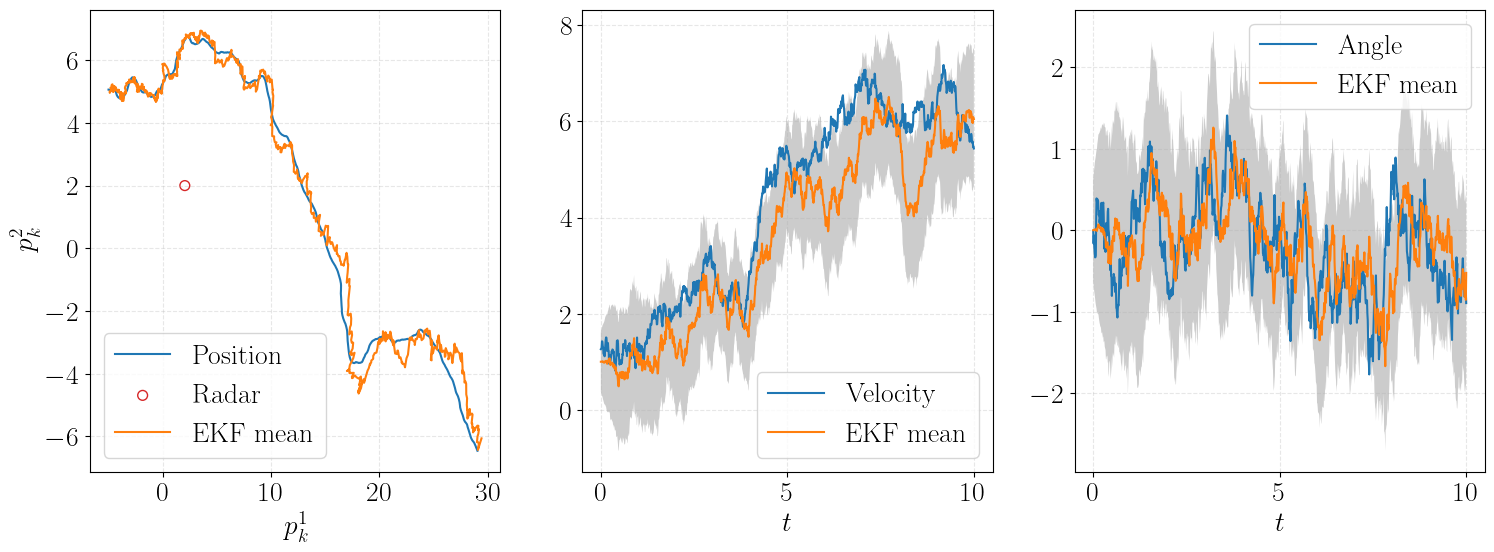

In [6]:
rmse_ekf = np.mean((xs - mfs) ** 2) ** 0.5
print(f'Kalman filter RMSE: {rmse_ekf:.3f}')

fig, axes = plt.subplots(ncols=3, figsize=(18, 6))
_ = axes[0].plot(xs[:, 0], xs[:, 1], label='Position')
_ = axes[0].scatter(r[0], r[1], s=50, edgecolors='tab:red', facecolors='none', label='Radar')
_ = axes[0].plot(mfs[:, 0], mfs[:, 1], label='EKF mean')

_ = axes[1].plot(ts, xs[:, 2], label='Velocity')
_ = axes[1].plot(ts, mfs[:, 2], label='EKF mean')
_ = axes[1].fill_between(ts,
                         mfs[:, 2] - 1.96 * vfs[:, 2, 2] ** 0.5,
                         mfs[:, 2] + 1.96 * vfs[:, 2, 2] ** 0.5,
                         color='black',
                         edgecolor='none',
                         alpha=0.2)

_ = axes[2].plot(ts, xs[:, 3], label='Angle')
_ = axes[2].plot(ts, mfs[:, 3], label='EKF mean')
_ = axes[2].fill_between(ts,
                         mfs[:, 3] - 1.96 * vfs[:, 3, 3] ** 0.5,
                         mfs[:, 3] + 1.96 * vfs[:, 3, 3] ** 0.5,
                         color='black',
                         edgecolor='none',
                         alpha=0.2)

axes[0].set_xlabel('$p^1_k$')
axes[0].set_ylabel('$p^2_k$')
axes[1].set_xlabel('$t$')
axes[2].set_xlabel('$t$')

for ax in axes:
    ax.grid(linestyle='--', alpha=0.3, which='both')
    ax.legend()

# Task 3: Quadrature filter

EKF is not the only way for Gaussian approximate filtering. Another popular choice is via numerical integration, e.g., the quadrature filters (some literature also calls them the sigma-points filters).

Now we move on to implementing the quadrature filter with spherical cubature integration, and let us call the resulting filter as *cubature Kalman filter (CKF)*.

## Spherical cubature integration
First, we should implement a function that gives us the quadrature points and weights for the spherical cubature integration.

In [7]:
def cubature_rule(m: np.ndarray,
                  v: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Compute the spherical cubature rule for the given mean and covariance.

    Parameters
    ----------
    m : np.ndarray (d, )
        The mean of the state.
    v : np.ndarray (d, d)
        The covariance of the state.

    Returns
    -------
    ws : np.ndarray (2 * d, )
        The weights of the cubature rule.
    zs : np.ndarray (2 * d, d)
        The quadrature points of the cubature rule.
    """
    ws = np.ones(2*d)*1/2/d
    
    # Add a small amount of "jitter" to ensure positive definiteness
    jitter = np.eye(d) * 1e-9
    
    L = scipy.linalg.cholesky(v+jitter, lower=True) #(d,d)
    
    # build the beta matrix
    b1= np.eye(d)*d**0.5 
    b2= - np.eye(d)*d**0.5
    b= np.concatenate([b1,b2], axis = 0) #(2d,d)
    zs = m + b @L.T
    return ws, zs

Now we can use `cubature_rule` to do the quadrature filter. It is almost the same as the EKF, following a prediction-update structure. The only difference is that we solve the expectations with the cubature rule instead of linearisation.

## Note
In the quadrature filter, we need to compute 1) evaluations of non-linear function at quadrature points, and 2) summations of weights times function evaluations. Here are some options to achieve this:

- Use a loop over the quadrature nodes. This is the most straightforward way, but you may end up with a slow and nasty implementation, also hard to debug.
- Use Numpy broadcasting rules, and then you may need to adapt your implementations for `f` and `h` properly (good). As an example, for now `f` is a function that takes a vector of shape `(d, )` as input and returns a vector of shape `(d, )` too. You ned to use broadcasting to let it accept input vector of shape `(..., d)` and output vector of shape `(..., d)`.
- (the best option but you need to do some learning) Use `einsum` and `vmap`. In NumPy these are `np.einsum` and `np.vectorize`. But remark that `np.vectorize` is merely a syntax sugar for the loop; it does *not* parallelise. A true vectorised implementation is `jax.vmap` in JAX.

In [8]:
def ckf_pred(mf, vf):
    # Given previous filtering mean and covariance, compute the predicted mean and covariance
    w, z = cubature_rule(mf, vf) # w: (2d,), z: (2d, d)

    # tell NumPy the signature, otherwise the shape collapses by default
    vfunc = np.vectorize(f, signature="(d)->(d)")  
    # vfunc(z) #(2d,d)
    mp = np.einsum('ij,i->j', vfunc(z),w) # (d,)
    # vfunc(z)-mp # (2d,d)
    diff = vfunc(z)-mp
    # w # (2d,)
    vp = np.einsum( 'ij,ik,i->jk', diff,diff ,w) + Sigma
    return mp, vp


def ckf_update(mp, vp, yk):
    # Given the predicted mean mp and covariance vp, update them with the new observation yk, to get the current filtering mean and covariance
    w, z = cubature_rule(mp, vp) # w: (2d,), z: (2d, d)
    # convert input dim (2d,d) to output dim (2d,dy0)
    # dim of output is recognized from definition of h
    vfunc = np.vectorize(h, signature="(n)->(m)")  #(2d, dy)

    
    mu_k = np.einsum('ij,i->j',vfunc(z),w) #(dy,)
    # w (2d,)
    # z-mp (2d,d)
    # vfunc(z) -mu_k (2d,dy)
    ck = np.einsum('i,ij,ik->jk',w, z-mp, vfunc(z)-mu_k)
    sk = np.einsum('i,ij,ik->jk',w, vfunc(z)-mu_k, vfunc(z)-mu_k) + xi
    
    # Cholesky factorization 
    cho_fac, lower = scipy.linalg.cho_factor(sk)
    sk_inv = scipy.linalg.cho_solve((cho_fac, lower), np.eye(dy))
    mf = mp +ck @ sk_inv@(yk-mu_k)
    vf = vp -ck @ sk_inv@ ck.T
    return mf, vf


def ckf(m0, v0):
    # Create a container to dump the filtering results
    mfs = np.zeros((nsteps + 1, d))  # Filtering means
    vfs = np.zeros((nsteps + 1, d, d))  # Filtering covariances

    # The initial step
    mf0, vf0 = ckf_update(m0, v0, y0)
    mfs[0] = mf0
    vfs[0] = vf0

    # KF loop
    for k in range(1, nsteps + 1):
        mp, vp = ckf_pred(mfs[k-1], vfs[k-1])
        mfs[k], vfs[k] = ckf_update(mp, vp, ys[k])

    return mfs, vfs


mfs, vfs = ckf(m0, v0)

Kalman filter RMSE: 0.468


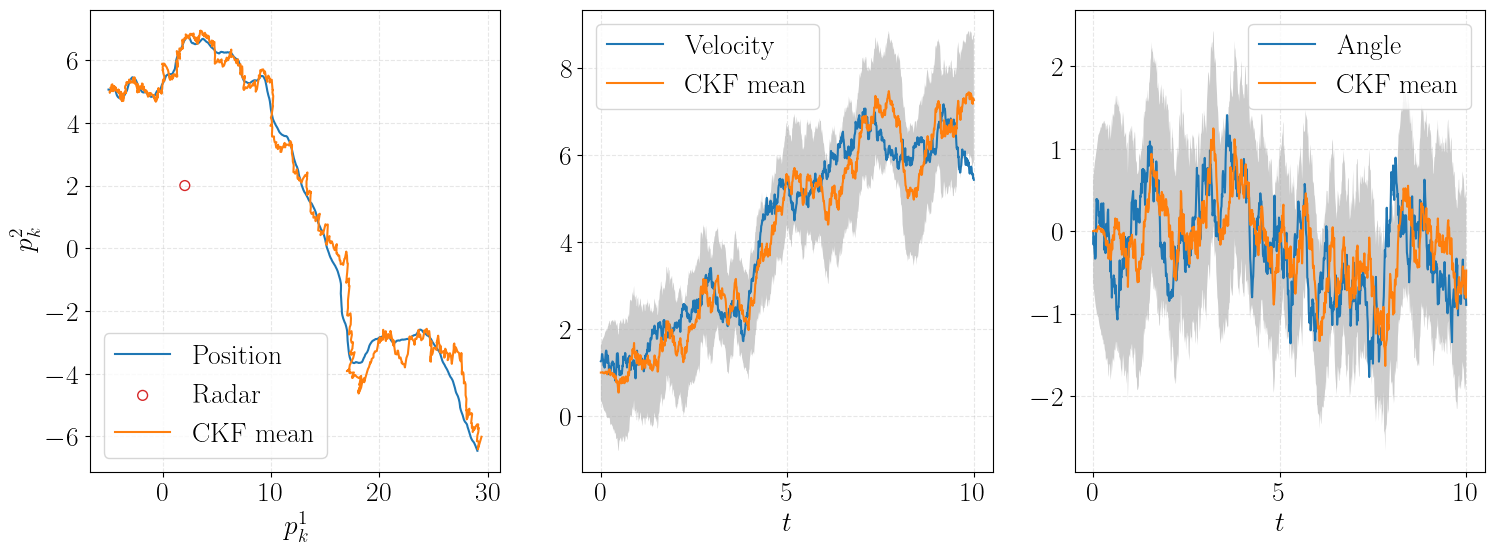

In [9]:
rmse_ckf = np.mean((xs - mfs) ** 2) ** 0.5
print(f'Kalman filter RMSE: {rmse_ckf:.3f}')

fig, axes = plt.subplots(ncols=3, figsize=(18, 6))
_ = axes[0].plot(xs[:, 0], xs[:, 1], label='Position')
_ = axes[0].scatter(r[0], r[1], s=50, edgecolors='tab:red', facecolors='none', label='Radar')
_ = axes[0].plot(mfs[:, 0], mfs[:, 1], label='CKF mean')

_ = axes[1].plot(ts, xs[:, 2], label='Velocity')
_ = axes[1].plot(ts, mfs[:, 2], label='CKF mean')
_ = axes[1].fill_between(ts,
                         mfs[:, 2] - 1.96 * vfs[:, 2, 2] ** 0.5,
                         mfs[:, 2] + 1.96 * vfs[:, 2, 2] ** 0.5,
                         color='black',
                         edgecolor='none',
                         alpha=0.2)

_ = axes[2].plot(ts, xs[:, 3], label='Angle')
_ = axes[2].plot(ts, mfs[:, 3], label='CKF mean')
_ = axes[2].fill_between(ts,
                         mfs[:, 3] - 1.96 * vfs[:, 3, 3] ** 0.5,
                         mfs[:, 3] + 1.96 * vfs[:, 3, 3] ** 0.5,
                         color='black',
                         edgecolor='none',
                         alpha=0.2)

axes[0].set_xlabel('$p^1_k$')
axes[0].set_ylabel('$p^2_k$')
axes[1].set_xlabel('$t$')
axes[2].set_xlabel('$t$')

for ax in axes:
    ax.grid(linestyle='--', alpha=0.3, which='both')
    ax.legend()

# Question 1

In the figures showing the filtering results, you can find `fill_between` that plots a shaded area to represent estimation uncertainty. How do you interpret this uncertainty and should we trust it?

The shaded area indicates the 95% confidence interval of the estimation, computed as `mean ± 1.96 × sqrt(variance)`. Wider range represents higher uncertainty. 
The model is built based on some assumptions, such as SSM is linearized by the first order Taylor expansion and the assumption that the posterior distribution is Gaussion. Despite the estimation is a comparatively good estimation of the realposition but we still need to be careful with relocate the same method to other cases.


# Question 2

How would you compare EKF and CKF? Summarise your opinions in the following pros-cons table.

| Method | Pros | Cons |
|--------|------|------|
| EKF    | Simple and efficient for mildly nonlinear or nearly linear systems, low computational cost | The linearization eero can be large and it requires Jacobians factorization  |
| CKF    | No need for Jacobians    | Computational expensive in high dimensions    |

# Question 3


So far we have assumed that the initial state $X_0$ is a Gaussian with mean $m_0$ and covariance $V_0$. What if the initial state is a fixed value not random, i.e., $X_0 = x_0$ a constant and no $m_0$ or $V_0$. How would you adapt your filter implementation for this case?


Since initial state is deterministic ($X_0 = x_0$), its $(m,V)$ can be interpreted as: $ m= X_0$ and $V =np.zeros(d, d)$ .Since $V_0 = 0$ can cause numerical problems (matrix inversion, Cholesky decomposition), we can use a very small covariance, e.g: $v0 = np.eye(d) * 1e-12$.  


# Contribution statement

If you have teamed up with someone, please write down the contribution of each team member in this cell. If you worked alone, you can leave this cell empty.


This assignment was completed as a team effort with equal contributions from Xiaochen and Nisal. Xiaochen is responsible for task 1 and 2, Nisal is responsible for task 3 and the question part.
